In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

In [5]:
opt_detector = "SIFT" #"ORB"   # option: "SIFT", "SURF", "ORB"
opt_matcher = "FLANN"  #"BF"     # option: "BF", "FLAN"

(<Axes: >, <matplotlib.image.AxesImage at 0x165de1005b0>)

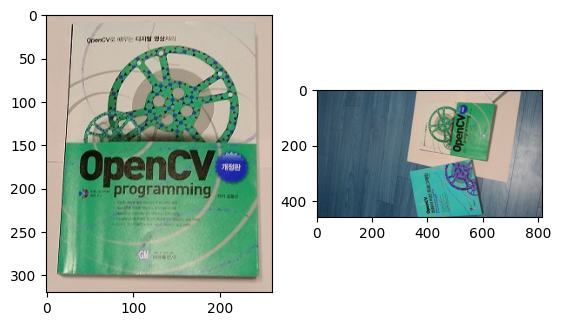

In [2]:
src1 = cv2.imread('./book1.jpg')
src2 = cv2.imread('./book2.jpg')
plt.subplot(1,2,1), plt.imshow(src1)
plt.subplot(1,2,2), plt.imshow(src2)

In [3]:
img1= cv2.cvtColor(src1,cv2.COLOR_BGR2GRAY) # 그레이 영상 이용  
img2= cv2.cvtColor(src2,cv2.COLOR_BGR2GRAY) 

In [6]:
if opt_detector == "SIFT": #  SIFT 사용 
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
elif opt_detector == "SURF": #  SURF 사용 
    surf = cv2.xfeatures2d.SURF_create()
    kp1, des1 = surf.detectAndCompute(img1, None)
    kp2, des2 = surf.detectAndCompute(img2, None)
elif opt_detector == "ORB": #  ORB 사용 
    orb = cv2.ORB_create()  # not ORB() due to the version issue 
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
else:
    print("Not support the Detector: ", opt_detector) 

In [6]:
print(len(kp1), len(des1))

597 597


In [7]:
print(len(kp2), len(des2))

881 881


(<Axes: >, <matplotlib.image.AxesImage at 0x165fec8b100>)

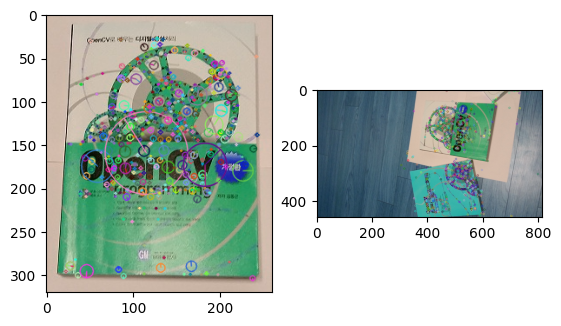

In [7]:
kpimg1  = cv2.drawKeypoints(src1, kp1, (255, 0, 0), flags = 4)  # 0: default, 4: rich 
kpimg2  = cv2.drawKeypoints(src2, kp2, (255, 0, 0), flags = 0)  # 
plt.subplot(1,2,1), plt.imshow(kpimg1)
plt.subplot(1,2,2), plt.imshow(kpimg2)

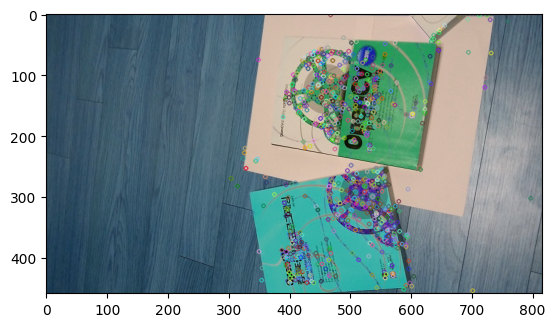

In [8]:
plt.imshow(kpimg2)

In [9]:
if opt_matcher == "BF":
    if opt_detector == "ORB":
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING) # crossCheck=True 를 사용하면 k 수를 2개로 할 수가 없음?
    else:
        matcher = cv2.BFMatcher()  # cv2.NORM_L2
        
    matches = matcher.knnMatch(des1, des2, k = 2)  # 가장 가까운 두개 (ratio test를 위하여)
elif opt_matcher == "FLANN":
    matcher = cv2.FlannBasedMatcher_create() 
    matches = matcher.knnMatch(des1, des2, k = 2) 
else:
    print("Not support the Matcher: ", opt_matcher) 


In [10]:
type(matches)
len(matches)

597

In [15]:
dir(matches[0][0])
#matches[0][0].distance

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'distance',
 'imgIdx',
 'queryIdx',
 'trainIdx']

In [16]:
for i, m in enumerate(matches[:3]):  # 너무 많으므로 일부만 출력 
    for j, n in enumerate(m):
        print('matches[{}][{}]=(queryIdx:{} => (trainImg:{}, trainIdx:{}), distance:{})'.format(
            i, j, n.queryIdx, n.imgIdx, n.trainIdx, n.distance))

matches[0][0]=(queryIdx:0 => (trainImg:0, trainIdx:198), distance:305.919921875)
matches[0][1]=(queryIdx:0 => (trainImg:0, trainIdx:541), distance:317.4192810058594)
matches[1][0]=(queryIdx:1 => (trainImg:0, trainIdx:542), distance:297.1666259765625)
matches[1][1]=(queryIdx:1 => (trainImg:0, trainIdx:467), distance:302.2664489746094)
matches[2][0]=(queryIdx:2 => (trainImg:0, trainIdx:403), distance:383.37841796875)
matches[2][1]=(queryIdx:2 => (trainImg:0, trainIdx:501), distance:433.54931640625)


In [17]:
dst = cv2.drawMatchesKnn(img1,kp1, img2, kp2, matches, None, flags=0) # 모든 매칭을 표시 

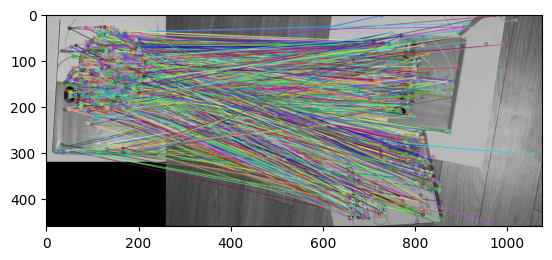

In [18]:
plt.imshow(dst)

In [19]:
nndrRatio = 0.5 #0.45  # SIFT 논문에서는 0.7 을 사용함.
##good_matches = []
##for f1, f2 in matches: # k = 2
##    if f1.distance < nndrRatio*f2.distance:
##        good_matches.append(f1)
good_matches = [f1 for f1, f2 in matches
                   if f1.distance < nndrRatio*f2.distance]
print('len(good_matches)=', len(good_matches))

len(good_matches)= 156


In [20]:
src1_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches])
src2_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches])

In [21]:
dst2 = cv2.drawMatches(src1,kp1,src2,kp2, good_matches, None,flags = 0)

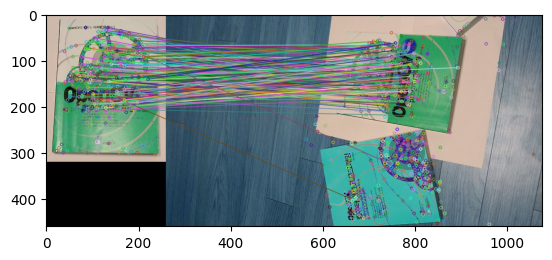

In [22]:
plt.imshow(dst2)

In [23]:
H, mask = cv2.findHomography(src1_pts, src2_pts, cv2.RANSAC, 0.1)#cv2.LMEDS
ransac_mask_matches = mask.ravel().tolist() # list(mask.flatten())
print("ransaced:", ransac_mask_matches)
print("H:", H)

ransaced: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
H: [[ 1.05571975e-01  6.78426679e-01  3.57335412e+02]
 [-8.34192621e-01  3.47702185e-02  2.38361133e+02]
 [-2.10658513e-05 -2.72862420e-04  1.00000000e+00]]


In [24]:
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
pts2 = cv2.perspectiveTransform(pts, H)
src2 = cv2.polylines(src2,[np.int32(pts2)],True,(255,0, 0),2)

In [25]:
      
draw_params = dict( #matchColor = (0,255,0),
                   singlePointColor = None,
                   matchesMask = ransac_mask_matches, flags = 2)                 
dst3 = cv2.drawMatches(src1,kp1,src2,kp2, good_matches, None,**draw_params)

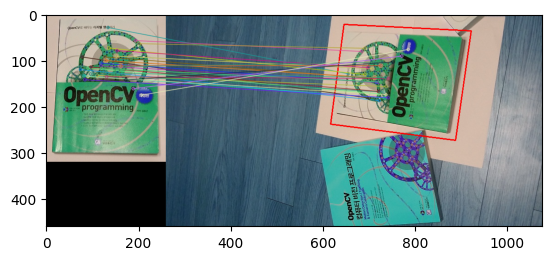

In [26]:
plt.imshow(dst3)

In [28]:
np.sum(ransac_mask_matches)

34